# Project 2: Reacher

---

In this notebook, I am going to implement the reacher agent of the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). 

This notebook is successfully solving the project via the DDPG algorithm. For more details also have a look at the [Readme](./README.md) of the project.

After training the agent, the neural network models for the actor and critic (as well as the replay buffer), will be saved to disk. You can use notebook [reacher-play](./reacher-play.ipynb) to load the neural network models and to see the agent in action.

## 1. Start the Environment

We begin by importing some necessary packages.

In [1]:
from unityagents import UnityEnvironment
from collections import deque

import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from modules.ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded. You can decide between headless and visual option. However, the headless option is a lot faster and at the end, the weights of the neural network will be stored to disk. You can use the trained weights in notebook [reacher-play](./reacher-play.ipynb), there we will just run the agent in a visual environment and you can see your agent in action.

- **Linux** (x86_64): `"./Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86_64, headless): `"./Reacher_Linux_NoVis/Reacher.x86_64"`

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux_NoVis/Reacher.x86')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

For this notebook, we decided to solve the simulation containing only a single agent that controls a single double-jointed arm that follows a goal location. At each time step, the agent has to choose the correct continuous action that consists of a vector of four entries. Each entry in the vector should be a number between -1 and +1:
- `x1` (-1; +1)
- `x2` (-1; +1)
- `x3` (-1; +1)
- `x4` (-1; +1)

The state space has `33` dimensions and corresponds to the position, rotation, velocity and angular velocities of the arm. A reward of `+0.1` is provided for keeping the "arm" within the target location. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

numberOfActions = action_size
numberOfStates = state_size

Number of agents: 1
Number of actions: 4
States look like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
States have length: 33


## 3. Define the main ddpg function and some helper functions

In [5]:
def ddpg(agent, n_episodes, max_t):
    environment_solved = False
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        agent.reset()                                      # reset the agent
        
        score = 0                                          # initialize the score

        for t in range(max_t):
            action = agent.act(state)
            
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state                             # roll over the state to next time step
            score += reward                                # update the score
            if done:                                       # exit loop if episode finished
                break 

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window) > 30.0 and environment_solved == False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            environment_solved = True
            
    return scores

def printPlot(title, scores, movingAverage=100):
    # plot the scores
    fig = plt.figure(1, figsize=(12, 12))
    
    mvgAvg = []
    scores_window = deque(maxlen=movingAverage)
    for s1 in scores:
        scores_window.append(s1)
        mvgAvg.append(np.mean(scores_window))    
    
    ax1 = fig.add_subplot(1,1,1)
    plt.plot(np.arange(len(scores)), scores, np.arange(len(scores)), mvgAvg)
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    
    plt.show()    
    
def writeScoreToFile(filename, scores):
    file = open("./models/" + filename, "w") 
 
    for score in scores:
        file.write(str(score) + "\n")
        
    file.close()

## 4. Run the DDGP algorithm

In [6]:
LR_ACTOR = 0.001
LR_CRITIC = 0.0001
WEIGHT_DECAY_CRITIC = 0.00001
REPLAY_BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
UPDATE_EVERY = 5
GAMMA = 0.99
TAU = 0.001
SEED = 0
MY_DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_episodes = 1000    # n_episodes (int): maximum number of training episodes
max_t = 1000

In [7]:
agent = Agent.for_training(
            state_size=numberOfStates, 
            action_size=numberOfActions,
              
            lr_actor=LR_ACTOR,
            lr_critic=LR_CRITIC,
            weight_decay_critic=WEIGHT_DECAY_CRITIC,
              
            replay_buffer_size=REPLAY_BUFFER_SIZE,
            batch_size=BATCH_SIZE,
            update_every=UPDATE_EVERY,
            gamma=GAMMA,
            tau=TAU,
              
            seed=SEED,
            device=MY_DEVICE)
#agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

scores_ddpg = ddpg(agent, n_episodes, max_t)
agent.save("./models/ddpg_")

cuda:0
Episode 100	Average Score: 2.47
Episode 200	Average Score: 29.80
Episode 201	Average Score: 30.13
Environment solved in 101 episodes!	Average Score: 30.13
Episode 300	Average Score: 39.25
Episode 400	Average Score: 38.54
Episode 500	Average Score: 38.38
Episode 600	Average Score: 38.44
Episode 700	Average Score: 38.24
Episode 800	Average Score: 38.53
Episode 900	Average Score: 38.15
Episode 1000	Average Score: 38.82


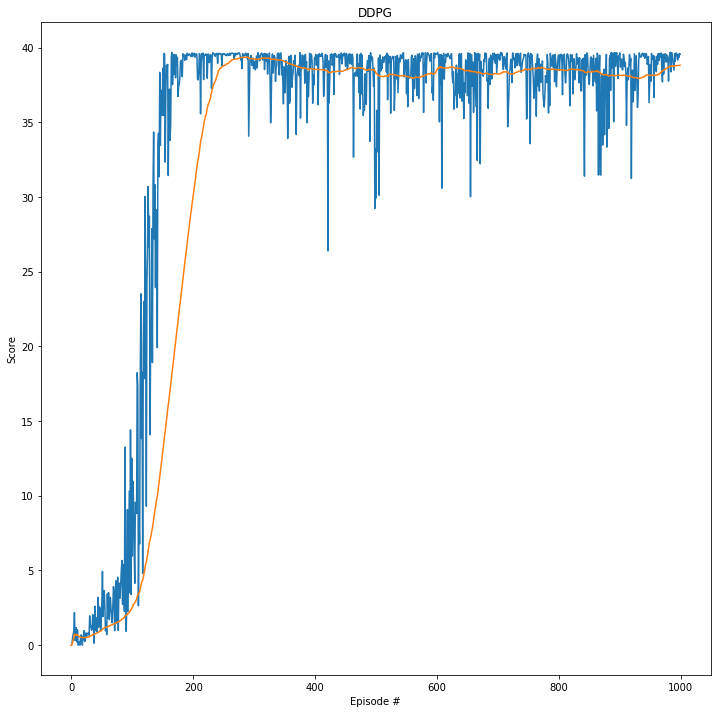

In [8]:
# plot the scores
printPlot("DDPG", scores_ddpg, 100)
writeScoreToFile("ddpg_scores.txt", scores_ddpg)

In [9]:
env.close()